In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
from pyedflib import highlevel
import yasa
import tqdm
import glob
import ghibtools as gt
import mne
from params import *

## PARAMS

In [3]:
input_file = glob.glob(f'../data/{patient}/*.edf')[0]

In [4]:
save_presentation = False

In [5]:
save_da = True

## TOOLS

In [6]:
def eeg_mono_to_bipol(da, dérivations):
    da_bipol = []
    for bipol in dérivations : 
        pole1, pole2 = bipol.split('-')[0] , bipol.split('-')[1]
        if pole1 in ['EOGDt','EOGG']:
            chan1 = pole1
            chan2 = f'EEG {pole2}'
        else:
            chan1 = f'EEG {pole1}'
            chan2 = f'EEG {pole2}'
        sig1 = da.loc[chan1,:]
        sig2 = da.loc[chan2,:]
        bipol_sig = sig1 - sig2
        da_bipol.append(bipol_sig)
    da_bipolaire = xr.concat(da_bipol, dim = 'chan')
    da_bipolaire = da_bipolaire.assign_coords({'chan':dérivations})
    return da_bipolaire

In [7]:
def to_notch_da(da, fs):
    chans = list(da.coords['chan'].values)
    da_notched = da.copy()
    for channel in chans:
        sig = da.sel(chan = channel).values
        sig_notched = gt.notch(sig, fs=fs)
        if channel == 'ECG':
            sig_notched = -sig_notched
        da_notched.loc[channel, :] = sig_notched
    return da_notched

In [8]:
def da_to_mne_object(da, srate):
    ch_names = list(da.coords['chan'].values)
    sfreq = srate
    info = mne.create_info(ch_names, sfreq, ch_types='misc', verbose=None)
    raw = mne.io.RawArray(data = da.values, info=info, first_samp=0, copy='auto', verbose=None)
    return raw

## LOAD RAW

In [9]:
signals, signal_headers, header = highlevel.read_edf(input_file)

In [10]:
srate = signal_headers[0]['sample_rate']
chans = [chan_dict['label'] for chan_dict in signal_headers]
eeg_chans = [ chan for chan in chans if 'EEG' in chan]
eeg_chans_clean = [ chan.split(' ')[1] for chan in chans if 'EEG' in chan]
eog_chans = [ chan for chan in chans if 'EOG' in chan] 
physio_chans = [ chan for chan in chans if not 'EEG' in chan] 
unit = signal_headers[0]['dimension']
time = np.arange(0 , signals.shape[1] / srate , 1 / srate)
dérivations = ['Fp2-C4' , 'C4-T4', 'T4-O2' , 'Fz-Cz' , 'Cz-Pz' , 'Fp1-C3', 'C3-T3', 'T3-O1', 'EOGDt-A1', 'EOGG-A2']
print(f'Srate : {srate}')
print(f'Total duration : {int(time[-1])} seconds')
print(f'Nb of eeg electrodes : {len(eeg_chans)}')
print(f'Nb physios electrodes : {len(physio_chans)}')

Srate : 256.0
Total duration : 32216 seconds
Nb of eeg electrodes : 13
Nb physios electrodes : 20


## PUT RAW IN DA

In [11]:
da = xr.DataArray(data = signals, dims = ['chan','time'] , coords = {'chan':chans , 'time':time})

## DISPLAY MONOPOLAR

* raw signals

<Figure size 432x288 with 0 Axes>

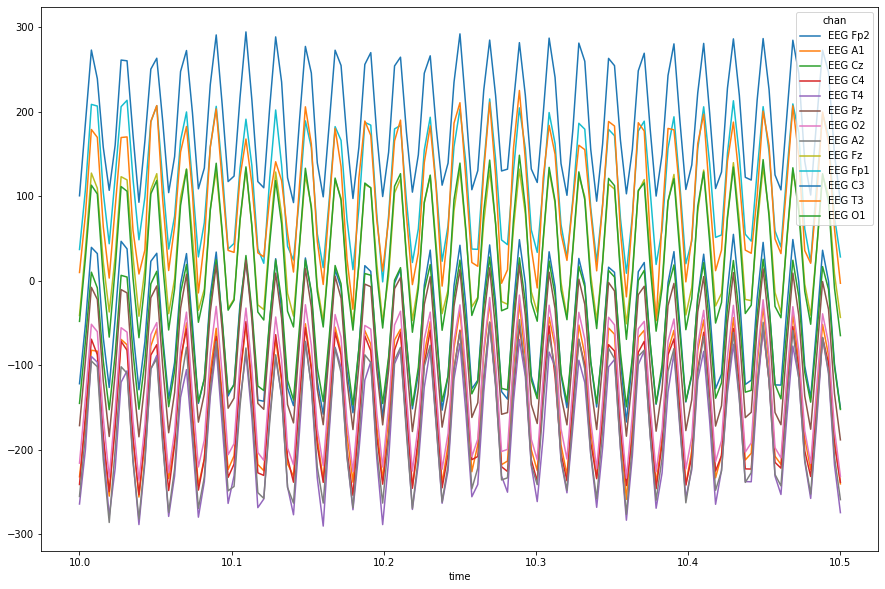

In [12]:
plt.figure()
da.loc[eeg_chans, 10:10.5].plot.line(x='time', hue = 'chan', size = 10)
if save_presentation:
    plt.savefig(f'../presentation/raw_signals_{patient}')
plt.show()

* psd of raw signals

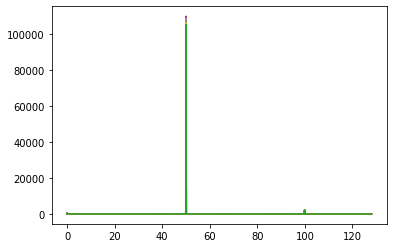

In [13]:
plt.figure()
for chan in eeg_chans :
    f, Pxx = gt.spectre(da.loc[chan,:].values, srate=srate, wsize = 50)
    plt.plot(f, Pxx)
if save_presentation:
    plt.savefig(f'../presentation/psd_raw_mono_{patient}')
plt.show()

## MONO TO BIPOLAR 

* signals

In [14]:
da_bipol = eeg_mono_to_bipol(da, dérivations = dérivations)

<Figure size 432x288 with 0 Axes>

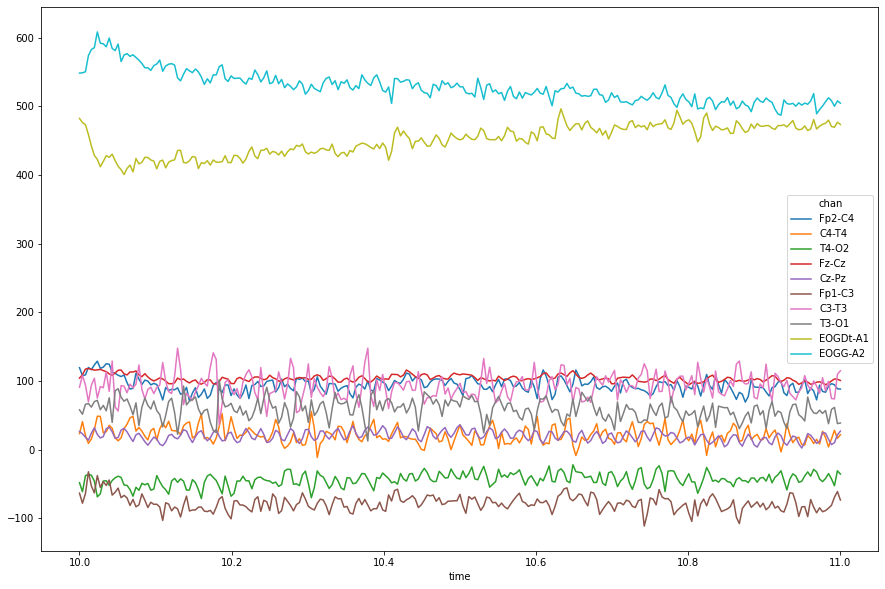

In [15]:
plt.figure()
da_bipol.loc[:,10:11].plot.line(x='time', hue = 'chan', size = 10)
if save_presentation:
    plt.savefig(f'../presentation/raw_bipol_signals_{patient}')
plt.show()

* psd

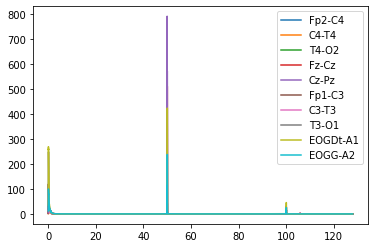

In [16]:
plt.figure()
for dérivation in dérivations:
    f, Pxx = gt.spectre(da_bipol.sel(chan = dérivation).values, srate=srate, wsize = 50)
    plt.plot(f, Pxx, label = dérivation)
    plt.legend()
if save_presentation:
    plt.savefig(f'../presentation/psd_raw_bipol_{patient}')
plt.show()

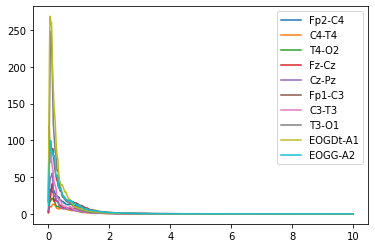

In [17]:
plt.figure()
for dérivation in dérivations:
    f, Pxx = gt.spectre(da_bipol.sel(chan = dérivation).values, srate=srate, wsize = 50)
    plt.plot(f[:1000], Pxx[:1000], label = dérivation)
    plt.legend()
plt.show()

* join bipol eeg to physios

In [18]:
da_physios = da.loc[physio_chans,:]

In [19]:
da_all = xr.concat([da_bipol , da_physios], dim = 'chan')

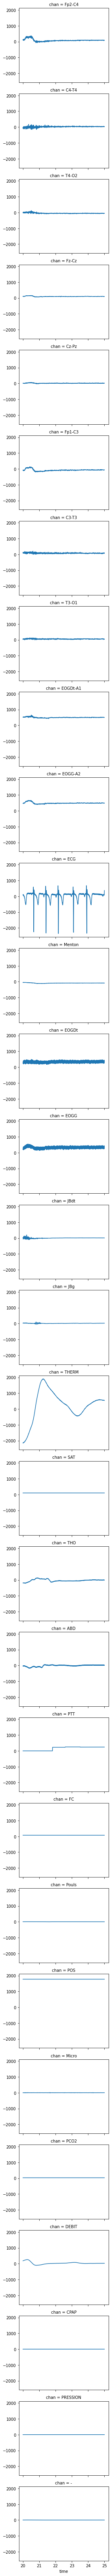

In [20]:
da_all.loc[:,20:25].plot.line(x='time', row = 'chan')

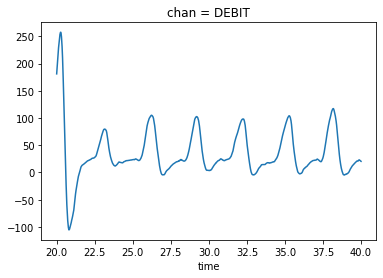

In [21]:
da_all.loc['DEBIT',20:40].plot()

In [22]:
da_all_notched = to_notch_da(da_all, fs=srate)

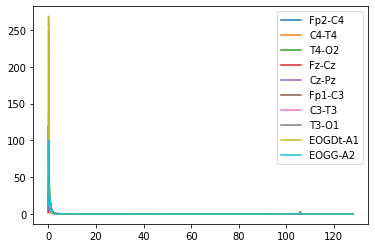

In [23]:
plt.figure()
for dérivation in dérivations:
    f, Pxx = gt.spectre(da_all_notched.sel(chan = dérivation).values, srate=srate, wsize = 50)
    plt.plot(f, Pxx, label = dérivation)
    plt.legend()
if save_presentation:
    plt.savefig(f'../presentation/psd_post_notch_{patient}')
plt.show()

In [24]:
raw = da_to_mne_object(da_all_notched, srate=srate)

Creating RawArray with float64 data, n_channels=30, n_times=8247552
    Range : 0 ... 8247551 =      0.000 ... 32216.996 secs
Ready.


In [25]:
eeg_names = [ chan for chan in dérivations if not chan in ['EOGDt-A1','EOGG-A2']]
eeg_names

['Fp2-C4', 'C4-T4', 'T4-O2', 'Fz-Cz', 'Cz-Pz', 'Fp1-C3', 'C3-T3', 'T3-O1']

## **YASA**

* read human marking

In [26]:
txt_hypno_path = glob.glob(f'../data/{patient}/*AhypnoEXP.txt')[0]

In [27]:
hypno = np.loadtxt(txt_hypno_path, dtype = str)

In [28]:
hypno = hypno[:,2]
pd.Series(hypno).value_counts()

N2     482
W      268
N3     155
REM    145
N1      23
dtype: int64

* yasa sleep staging by giving "preferentially a central electrode" = C4-T4, eog ("preferentially, the left LOC channel referenced either to the mastoid (e.g. E1-M2) or Fpz.") = Left EOG reref to A1 , emg = menton ("Preferentially a chin electrode.")

In [29]:
sls = yasa.SleepStaging(raw , eeg_name = 'C4-T4' , eog_name = 'EOGG-A2', emg_name='Menton')

In [30]:
y_pred = sls.predict()
y_pred

/home/valentin.ghibaudo/.virtualenvs/py38_cluster/lib64/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array(['W', 'W', 'W', ..., 'W', 'W', 'W'], dtype=object)

In [31]:
# What are the predicted probabilities of each sleep stage at each epoch?
predict_probas = sls.predict_proba()
predict_probas

,N1,N2,N3,R,W
epoch,,,,,
0,4.345969e-07,0.000009,0.000018,0.000001,0.999971
1,1.140353e-05,0.000009,0.000012,0.000002,0.999965
2,5.373527e-05,0.000051,0.000039,0.000007,0.999848
3,1.014218e-04,0.000073,0.000011,0.000026,0.999789
4,3.348510e-05,0.000071,0.000006,0.000071,0.999818
...,...,...,...,...,...
1068,2.702846e-02,0.006455,0.000287,0.003221,0.963008
1069,1.293223e-02,0.004750,0.000056,0.001534,0.980728
1070,4.122365e-03,0.001126,0.000116,0.000816,0.993819


* plot yasa sleep staging

<Figure size 432x288 with 0 Axes>

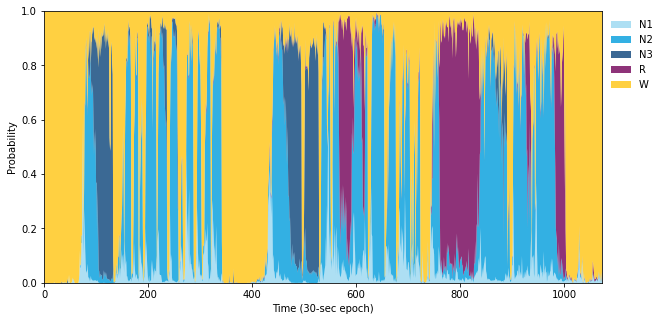

In [32]:
# Plot the predicted probabilities
plt.figure()
sls.plot_predict_proba();
if save_presentation:
    plt.savefig('../presentation/yasa_sleep_staging')
plt.show()

* display human vs yasa sleep staging

In [33]:
n_epochs_ia = pd.Series(y_pred).size
ia_stages = pd.Series(y_pred).value_counts().reindex(index = stages_labels) # IA staging
n_epochs_human = pd.Series(hypno).size
human_stages = pd.Series(hypno).value_counts().rename({'REM':'R'}).reindex(index = stages_labels)  # human staging
df_staging_compare = pd.concat([ia_stages, human_stages] , axis = 1).rename(columns = {0:'ia',1:'human'}).T
df_staging_compare.insert(0,  'patient' , patient)
df_staging_compare = df_staging_compare.reset_index().set_index(['index','patient'])
if save_da:
    df_staging_compare.to_excel(f'../df_analyse/df_staging_compare_{patient}.xlsx')
df_staging_compare

,,W,R,N1,N2,N3
index,patient,,,,,
ia,P10,431,131,5,417,89
human,P10,268,145,23,482,155


* make a 30 sec epoched da multi_indexed via epoch num & epoch sleep stage label

In [34]:
y_pred_series = pd.Series(y_pred)
y_pred_series.value_counts()

W     431
N2    417
R     131
N3     89
N1      5
dtype: int64

In [35]:
y_pred_series

0       W
1       W
2       W
3       W
4       W
       ..
1068    W
1069    W
1070    W
1071    W
1072    W
Length: 1073, dtype: object

In [36]:
epochs = np.arange(0, y_pred_series.size, 1)
da_epoched = gt.init_da({'chan':da_all_notched.coords['chan'].values, 'epoch':epochs, 'time':np.arange(0, 30, 1 / srate)})

In [37]:
da_epoched.shape

(30, 1073, 7680)

In [38]:
for epoch in epochs:
    start = (epoch) * 30  
    stop = start + 30
    epoch_slice = da_all_notched.loc[:,start:stop].values[:,:-1]
    da_epoched.loc[:, epoch, :] = epoch_slice

In [39]:
da_epoched

<xarray.DataArray (chan: 30, epoch: 1073, time: 7680)>
array([[[ 1.08645914e+02,  1.11779921e+02,  1.07976082e+02, ...,
          6.47372028e+01,  6.15264452e+01,  7.11249359e+01],
        [ 6.55632798e+01,  7.37810084e+01,  6.02145963e+01, ...,
         -2.33049885e-01,  3.28103140e+00,  5.58995945e+00],
        [ 4.32318090e-01, -2.83773329e-02, -1.46693515e+01, ...,
          1.06872866e+02,  1.20038777e+02,  1.18912556e+02],
        ...,
        [ 1.93670577e+02,  1.81364864e+02,  1.94663413e+02, ...,
          1.69079727e+02,  1.80341088e+02,  1.73185491e+02],
        [ 1.51992032e+02,  1.67692927e+02,  1.71487260e+02, ...,
          1.99078213e+02,  1.98207964e+02,  1.87961828e+02],
        [ 1.98804196e+02,  1.96765740e+02,  1.99417187e+02, ...,
          1.91678374e+02,  1.95765364e+02,  1.97916058e+02]],

       [[ 3.61556420e+01,  2.59379050e+01,  9.88824413e+00, ...,
          1.66709370e+01,  3.77822908e+00,  9.65799697e+00],
        [ 2.44514263e+01,  2.36446468e+01,  2.38731602e+01, ...,
          2.42874412e+01,  2.00092630e+01,  2.45888456e+01],
        [ 1.91575156e+01,  2.26021703e+01,  3.06951428e+01, ...,
         -2.80088260e+00,  4.90706283e+00,  9.42277099e+00],
...
        [-1.27321373e+00, -1.27599065e+00, -1.27435300e+00, ...,
         -1.27141338e+00, -1.26989969e+00, -1.26692415e+00],
        [-1.26890405e+00, -1.26982560e+00, -1.27233493e+00, ...,
         -1.27361092e+00, -1.27212850e+00, -1.26924065e+00],
        [-1.27436689e+00, -1.27281213e+00, -1.27119857e+00, ...,
         -1.27692053e+00, -1.27669190e+00, -1.27704659e+00]],

       [[ 2.26977951e+00,  2.34359606e+00,  2.34068340e+00, ...,
          2.11766749e+00,  2.08685017e+00,  2.08213961e+00],
        [ 2.07044372e+00,  2.03808567e+00,  2.04101086e+00, ...,
          1.35468716e+00,  1.30670225e+00,  1.24723059e+00],
        [ 1.28344950e+00,  1.27348631e+00,  1.27940259e+00, ...,
          1.80921793e+00,  1.84652750e+00,  1.85082876e+00],
        ...,
        [ 1.61637555e+00,  1.62187395e+00,  1.67139123e+00, ...,
          1.61116409e+00,  1.58588977e+00,  1.62687884e+00],
        [ 1.66619132e+00,  1.57946058e+00,  1.61028725e+00, ...,
          1.62105053e+00,  1.62745736e+00,  1.58913623e+00],
        [ 1.57950607e+00,  1.57532252e+00,  1.58183952e+00, ...,
          1.58757410e+00,  1.62052757e+00,  1.54139396e+00]]])
Coordinates:
  * chan     (chan) <U8 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'CPAP' 'PRESSION' '-'
  * epoch    (epoch) int64 0 1 2 3 4 5 6 ... 1066 1067 1068 1069 1070 1071 1072
  * time     (time) float64 0.0 0.003906 0.007812 0.01172 ... 29.99 29.99 30.0

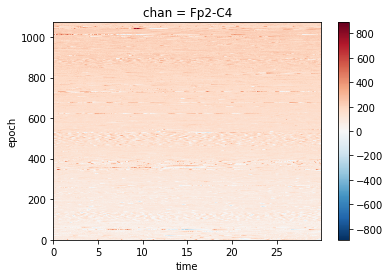

In [40]:
da_epoched.loc['Fp2-C4',:,:].plot()

In [41]:
midx = [epochs, y_pred_series.values]
midx_ready = pd.MultiIndex.from_arrays(midx, names=('epochs', 'stages'))
da_epoched_midx = da_epoched.assign_coords(coords = {'epoch':midx_ready})

In [42]:
da_epoched_midx

<xarray.DataArray (chan: 30, epoch: 1073, time: 7680)>
array([[[ 1.08645914e+02,  1.11779921e+02,  1.07976082e+02, ...,
          6.47372028e+01,  6.15264452e+01,  7.11249359e+01],
        [ 6.55632798e+01,  7.37810084e+01,  6.02145963e+01, ...,
         -2.33049885e-01,  3.28103140e+00,  5.58995945e+00],
        [ 4.32318090e-01, -2.83773329e-02, -1.46693515e+01, ...,
          1.06872866e+02,  1.20038777e+02,  1.18912556e+02],
        ...,
        [ 1.93670577e+02,  1.81364864e+02,  1.94663413e+02, ...,
          1.69079727e+02,  1.80341088e+02,  1.73185491e+02],
        [ 1.51992032e+02,  1.67692927e+02,  1.71487260e+02, ...,
          1.99078213e+02,  1.98207964e+02,  1.87961828e+02],
        [ 1.98804196e+02,  1.96765740e+02,  1.99417187e+02, ...,
          1.91678374e+02,  1.95765364e+02,  1.97916058e+02]],

       [[ 3.61556420e+01,  2.59379050e+01,  9.88824413e+00, ...,
          1.66709370e+01,  3.77822908e+00,  9.65799697e+00],
        [ 2.44514263e+01,  2.36446468e+01,  2.38731602e+01, ...,
          2.42874412e+01,  2.00092630e+01,  2.45888456e+01],
        [ 1.91575156e+01,  2.26021703e+01,  3.06951428e+01, ...,
         -2.80088260e+00,  4.90706283e+00,  9.42277099e+00],
...
        [-1.27321373e+00, -1.27599065e+00, -1.27435300e+00, ...,
         -1.27141338e+00, -1.26989969e+00, -1.26692415e+00],
        [-1.26890405e+00, -1.26982560e+00, -1.27233493e+00, ...,
         -1.27361092e+00, -1.27212850e+00, -1.26924065e+00],
        [-1.27436689e+00, -1.27281213e+00, -1.27119857e+00, ...,
         -1.27692053e+00, -1.27669190e+00, -1.27704659e+00]],

       [[ 2.26977951e+00,  2.34359606e+00,  2.34068340e+00, ...,
          2.11766749e+00,  2.08685017e+00,  2.08213961e+00],
        [ 2.07044372e+00,  2.03808567e+00,  2.04101086e+00, ...,
          1.35468716e+00,  1.30670225e+00,  1.24723059e+00],
        [ 1.28344950e+00,  1.27348631e+00,  1.27940259e+00, ...,
          1.80921793e+00,  1.84652750e+00,  1.85082876e+00],
        ...,
        [ 1.61637555e+00,  1.62187395e+00,  1.67139123e+00, ...,
          1.61116409e+00,  1.58588977e+00,  1.62687884e+00],
        [ 1.66619132e+00,  1.57946058e+00,  1.61028725e+00, ...,
          1.62105053e+00,  1.62745736e+00,  1.58913623e+00],
        [ 1.57950607e+00,  1.57532252e+00,  1.58183952e+00, ...,
          1.58757410e+00,  1.62052757e+00,  1.54139396e+00]]])
Coordinates:
  * chan     (chan) <U8 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'CPAP' 'PRESSION' '-'
  * epoch    (epoch) MultiIndex
  - epochs   (epoch) int64 0 1 2 3 4 5 6 ... 1066 1067 1068 1069 1070 1071 1072
  - stages   (epoch) object 'W' 'W' 'W' 'W' 'W' 'W' ... 'W' 'W' 'W' 'W' 'W' 'W'
  * time     (time) float64 0.0 0.003906 0.007812 0.01172 ... 29.99 29.99 30.0

In [43]:
def stack_stages(da_midx, stage, srate = srate):
    da = da_midx.sel(stages = stage)
    epochs = list(da.coords['epochs'].values)
    to_concat = []
    for epoch in epochs:
        da_epoch = da.sel(epochs = epoch).reset_coords(drop=True)
        to_concat.append(da_epoch)
    da_concat = xr.concat(to_concat, dim = 'time')
    time_vector = np.arange(0,da_concat.shape[1]/srate, 1/srate)
    da_return = da_concat.assign_coords({'time':time_vector}) 
    return da_return

In [44]:
da_stacked_stage = stack_stages(da_midx = da_epoched_midx, stage=stage_to_study)

In [45]:
da_stacked_stage

<xarray.DataArray (chan: 30, time: 3202560)>
array([[ 9.97961028e+01,  9.78245223e+01,  9.58710408e+01, ...,
         2.17710750e+02,  2.17343681e+02,  2.16662896e+02],
       [ 5.72698123e+01,  5.90547941e+01,  5.96600247e+01, ...,
        -4.67884969e+01, -4.80349721e+01, -4.87314812e+01],
       [-2.88983473e+01, -2.83513051e+01, -2.56071060e+01, ...,
        -3.31188722e+01, -3.46614456e+01, -3.59299381e+01],
       ...,
       [ 1.90737774e-02,  1.90737774e-02,  1.90737774e-02, ...,
         1.90737774e-02,  1.90737774e-02,  1.90737774e-02],
       [-1.24677295e+00, -1.24899475e+00, -1.24874837e+00, ...,
        -1.26089603e+00, -1.26011111e+00, -1.26042198e+00],
       [ 1.92609507e+00,  1.95678999e+00,  1.96588313e+00, ...,
         1.59122326e+00,  1.58592375e+00,  1.66119214e+00]])
Coordinates:
  * chan     (chan) <U8 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'CPAP' 'PRESSION' '-'
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.251e+04 1.251e+04

* stack the 30 sec epoched da multi_indexed to get one signal by chan and by stage (concat staged epochs)

In [46]:
def stack_all_stages(da_midx, stages=stages_labels, srate=srate):
    concat = []
    for stage in stages:
        da_stage = stack_stages(da_midx=da_midx, stage=stage, srate = srate)
        concat.append(da_stage)
    da_all_stages = xr.concat(concat, dim = 'stage')
    da_all_stages = da_all_stages.assign_coords({'stage':stages})
    return da_all_stages

In [47]:
da_all_stages = stack_all_stages(da_midx=da_epoched_midx)

In [48]:
da_all_stages

<xarray.DataArray (stage: 5, chan: 30, time: 3310080)>
array([[[ 1.08645914e+02,  1.11779921e+02,  1.07976082e+02, ...,
          1.91678374e+02,  1.95765364e+02,  1.97916058e+02],
        [ 3.61556420e+01,  2.59379050e+01,  9.88824413e+00, ...,
         -3.70798613e+01, -4.40567300e+01, -3.93865192e+01],
        [-7.64280156e+01, -6.14029190e+01, -5.16604557e+01, ...,
         -4.85311950e+01, -4.59266837e+01, -5.16376868e+01],
        ...,
        [ 1.90737774e-02,  1.90737774e-02,  1.90737774e-02, ...,
          1.90737774e-02,  1.90737774e-02,  1.90737774e-02],
        [-1.26102083e+00, -1.26599711e+00, -1.26467141e+00, ...,
         -1.27692053e+00, -1.27669190e+00, -1.27704659e+00],
        [ 2.26977951e+00,  2.34359606e+00,  2.34068340e+00, ...,
          1.58757410e+00,  1.62052757e+00,  1.54139396e+00]],

       [[ 1.39144858e+02,  1.39881724e+02,  1.39699210e+02, ...,
                     nan,             nan,             nan],
        [ 5.91428861e-01,  1.16344616e+00,  6.88635624e-01, ...,
                     nan,             nan,             nan],
        [-3.02271009e+01, -2.98399929e+01, -2.87210900e+01, ...,
                     nan,             nan,             nan],
...
        [ 1.90737774e-02,  1.90737774e-02,  1.90737774e-02, ...,
                     nan,             nan,             nan],
        [-1.24677295e+00, -1.24899475e+00, -1.24874837e+00, ...,
                     nan,             nan,             nan],
        [ 1.92609507e+00,  1.95678999e+00,  1.96588313e+00, ...,
                     nan,             nan,             nan]],

       [[ 9.98313925e+01,  9.99595675e+01,  9.83282059e+01, ...,
                     nan,             nan,             nan],
        [ 4.26393290e+01,  4.37281370e+01,  4.50940229e+01, ...,
                     nan,             nan,             nan],
        [-3.78230647e+01, -3.72196970e+01, -3.72015447e+01, ...,
                     nan,             nan,             nan],
        ...,
        [ 1.90737774e-02,  1.90737774e-02,  1.90737774e-02, ...,
                     nan,             nan,             nan],
        [-1.26606729e+00, -1.26325518e+00, -1.26539902e+00, ...,
                     nan,             nan,             nan],
        [ 1.58472284e+00,  1.69076238e+00,  1.69539693e+00, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.293e+04 1.293e+04
  * chan     (chan) <U8 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'CPAP' 'PRESSION' '-'
  * stage    (stage) <U2 'W' 'R' 'N1' 'N2' 'N3'

* duration by stage

In [49]:
def get_duration_by_stade(da_all=da_all_stages, stages=stages_labels):
    for stage in stages: 
        da_sel = da_all.sel(stage=stage).dropna(dim='time')
        print( stage ,int( da_sel.coords['time'].values[-1]))

In [50]:
get_duration_by_stade()

W 12929
R 3929
N1 149
N2 12509
N3 2669


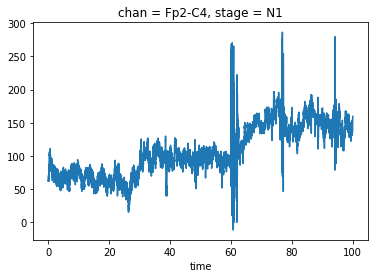

In [51]:
da_all_stages.loc['N1','Fp2-C4',0:100].plot.line(x='time', hue = 'stage')

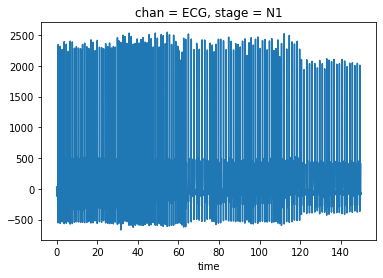

In [52]:
da_all_stages.loc['N1','ECG',:].plot()

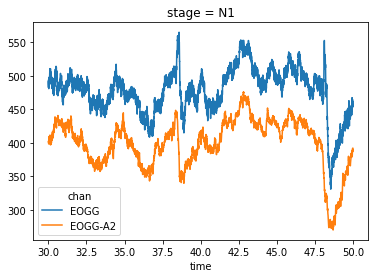

In [53]:
da_all_stages.loc['N1',['EOGG','EOGG-A2'],30:50].plot.line(x='time', hue='chan')

In [54]:
if save_da:
    da_all_stages.to_netcdf(f'../dataarray/da_staged_{patient}.nc')

In [55]:
print(f'Srate : {srate}')
print(f'Total duration : {int(time[-1])} seconds')
print(f'Nb of eeg electrodes : {len(eeg_chans)}')
print(f'Nb physios electrodes : {len(physio_chans)}')
print(f"YASA trouve {n_epochs_ia} époques de 30 secs, hypnogramme human made en note {n_epochs_human} soit {n_epochs_human - n_epochs_ia} de plus soit {(n_epochs_human - n_epochs_ia) * 30} secondes de plus")
get_duration_by_stade()

Srate : 256.0
Total duration : 32216 seconds
Nb of eeg electrodes : 13
Nb physios electrodes : 20
YASA trouve 1073 époques de 30 secs, hypnogramme human made en note 1073 soit 0 de plus soit 0 secondes de plus
W 12929
R 3929
N1 149
N2 12509
N3 2669
